In [42]:
import sys
import time
import numpy as np
import math
import pandas as pd
from sklearn.utils.validation import check_X_y
from honest_forests.estimators import HonestForestClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.validation import check_X_y
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import scipy.stats as stats
from joblib import Parallel, delayed
import copy
from tensorflow import keras

In [43]:
def Posterior_After(X,v,X_sample,tree_i):
    
    #Duplicate the sigle sample test
    X_testsample_duplicated = np.tile(X,(X_sample.shape[0],1))
    
    ### Replace test data with values from structure subset   
    X_variable = X_sample[:,v]
    
    X_testsample_duplicated[:,v] = X_variable
    X_testsample_duplicated = X_testsample_duplicated.astype(np.float32)
    
    #Obtain the possiblea leaves with ignoring variable v
    leaves_indicies = np.unique(tree_i.tree_.apply(X_testsample_duplicated)) 
    value_leaves = np.sum(tree_i.tree_.value[leaves_indicies], axis=0)
    
    #Calculate the posterior probability for sample x
    
    posterior_proba = value_leaves/np.sum(value_leaves) 
    
    
    return value_leaves,posterior_proba
    
    

In [44]:
def SCORE(tree_i,X,y):
    X_structure = X[tree_i.structure_indices_]
    X_honest = X[tree_i.honest_indices_]
    y_honest  = y[tree_i.honest_indices_]
        
    leaves_indicies_before = tree_i.tree_.apply(X_honest.astype(np.float32))
    value_leaves_before = tree_i.tree_.value[leaves_indicies_before]
    classification_before = np.zeros(X_honest.shape[0])
    #error_before = np.zeros((X_honest.shape[0],1))
        
    posterior_proba_before = np.zeros((X_honest.shape[0],3))##n_classes
    value_leaves = np.zeros((X_honest.shape[0],3))
    posterior_proba = np.zeros((X_honest.shape[0],3))
    classification_after = np.zeros(X_honest.shape[0])
    difference_clf = np.zeros(X_honest.shape[0])
    #error_after = np.zeros((X_honest.shape[0],1))
        
    mean_diff = np.zeros(X_honest.shape[1])
    feature_org = pd.unique(tree_i.tree_.feature)
    feature = feature_org[feature_org>=0]
    #print(feature)
    for k in feature:
        #print(k)
        # posterior_proba_before = np.divide(value_leaves_before,np.sum(value_leaves_before,axis = 1))
        # print(posterior_proba_before)
        #value_leaves,posterior_proba = pd.DataFrame(X_honest).apply(Posterior_After,args = (k,X_structure,tree_i),axis = 1)

        for i in range(0,X_honest.shape[0]):
            ##Compute posterior probability before merging
            posterior_proba_before[i,:] = value_leaves_before[i,:]/np.sum(value_leaves_before[i,:])
            ##Compute posterior probability after merging
            value_leaves[i,:],posterior_proba[i,:] = Posterior_After(X_honest[i,:],k,X_structure,tree_i)
            #Compute the difference of posterior possibility for just one class
            
        ## Get the classification_before result
        classification_before = posterior_proba_before.argmax(1)
        #print(classification_before)
        ## Get the classification_after result
        classification_after = posterior_proba.argmax(1)
            
        #Calculate classification error before 
        error_before = np.mean(np.abs(y_honest - classification_before))
        #Calculate classification error after merging leaves
        error_after = np.mean(np.abs(y_honest - classification_after))
        #Calculate the difference of classification error
        difference_clf = error_after - error_before
        mean_diff[k] = difference_clf
    return mean_diff

In [45]:
def Permutation(X,y,CLASSIFIER):
    Y_predict_before = CLASSIFIER.predict(X)
    predict_error = np.mean(np.abs(Y_predict_before-y))
    feature = []
    for tree_i in CLASSIFIER.estimators_:
        feature_org_i = pd.unique(tree_i.tree_.feature)
        feature_i = feature_org_i[feature_org_i>=0]
        feature = pd.unique([int(x) for x in pd.unique(np.append(feature,feature_i))])
    permutation_score = np.zeros(X.shape[1])
    for k in feature:
        #print(k)
        score_k = []
        for i in range(0,5):
            #print(X[:,k])
            X_k = copy.copy(X)
            #print(X_k)
            X_k[:,k] = shuffle(X[:,k])
            #print(X_k[:,k])
            #print(X[:,k])
            Y_predict_after = CLASSIFIER.predict(X_k)
            predict_error_after = np.mean(np.abs(Y_predict_after-y))
            #print(predict_error_after)
            score_k = np.append(score_k,predict_error_after-predict_error)
        permutation_score[k] = np.mean(score_k)
    print(permutation_score)
    return permutation_score
            


In [46]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train/255.0
nsamples, nx, ny, nrgb = x_train.shape
x_train2 = x_train.reshape((nsamples,nx*ny*nrgb))

x_test = x_test/255.0
nsamples_test, nx_test, ny_test, nrgb_test = x_test.shape
x_test2 = x_test.reshape((nsamples_test,nx_test*ny_test*nrgb_test))

In [47]:
X_train_total = x_train2[np.argwhere(y_train<3)[:,0],:]
y_train_total = y_train[np.argwhere(y_train<3)[:,0],:]
print(y_train_total.shape)



X_test_total = x_test2[np.argwhere(y_test<3)[:,0],:]
y_test_total = y_test[np.argwhere(y_test<3)[:,0],:]
print(y_test_total.shape)

(15000, 1)
(3000, 1)


In [416]:
N = 5
d = 32*32*3
n_estimator = 100
honest_frac = [0.1,0.3,0.5,0.7]
samples_space = np.geomspace(625, 5, num=4, dtype=int)
ERROR_rf = np.zeros([3,N])
ERROR_hf = np.zeros([3,N,len(honest_frac)])
TIC_RFP = np.zeros([3,N])
TIC_HF = np.zeros([3,N,len(honest_frac)])
TIC_HFP = np.zeros([3,N,len(honest_frac)])

SCORE_RFP= np.zeros([3,N,d])
SCORE_HF= np.zeros([3,N,len(honest_frac),d])
SCORE_HFP= np.zeros([3,N,len(honest_frac),d])

n_sample = 0
for sample_size_i in samples_space[1:]:
    print(sample_size_i)
    #error = np.zeros((N,4))
    error_rf = []
    Error_hf = np.zeros((N,len(honest_frac)))
    score_rfp = np.zeros((N,d))
    Score_hf = np.zeros([N,len(honest_frac),d])
    Score_hfp = np.zeros([N,len(honest_frac),d])
    TIC_1 = np.zeros((N,len(honest_frac)))
    TIC_2 = np.zeros((N,len(honest_frac)))
    TIC_3 = []
    for num in range(0,N):
        print(num)
        Data = shuffle(np.hstack([X_train_total, y_train_total]))
        nsample2 = X_train_total.shape[0]
        #print(nsample2)
        X_train = Data[np.arange(0,nsample2,3*sample_size_i),0:-1]
        Y_train = Data[np.arange(0,nsample2,3*sample_size_i),-1].ravel()
        print(X_train.shape[0])
        #print(y_train)

        Data_test = shuffle(np.hstack([X_test_total, y_test_total]))
        nsample_test2 = X_test_total.shape[0]
        X_test = Data_test[np.arange(0,nsample_test2,1),0:-1]
        Y_test = Data_test[np.arange(0,nsample_test2,1),-1].ravel()

        tic_rf = time.perf_counter()
        clf_rf = RandomForestClassifier(n_estimators = n_estimator,max_features = d,bootstrap = False)
        clf_rf = clf_rf.fit(X_train, Y_train)
        toc_rf = time.perf_counter()
        print("finish")
        y_predict_rf = clf_rf.predict(X_test)
        indicator_rf = [0 if Y_test[i] == y_predict_rf[i] else 1 for i in range(len(Y_test))]
        predict_error_rf = np.mean(indicator_rf)
        error_rf = np.append(error_rf,predict_error_rf)

        print("finish")
        print("prediction error" + str(predict_error_rf))
        
        tic_3 = time.perf_counter()
        r_rf = Permutation(X_train,Y_train,clf_rf)
        score_rfp[num,:] = r_rf
        toc_3 = time.perf_counter()
        print("TIME_RF " + str(toc_rf-tic_rf))
        print("TIME_RFP " + str(toc_3-tic_3))
        TIC_3.append(toc_rf-tic_rf + toc_3-tic_3)
        

        ################################################
        
        score_hf = np.zeros((len(honest_frac),d))
        score_hfp = np.zeros((len(honest_frac),d))
        num_hf = 0
        error_hf = []
        Tic_hf = []
        Tic_hfp = []


        for honest_frac_i in honest_frac:
            print("honest_frac = " + str(honest_frac_i))
            tic_hf = time.perf_counter()
            clf = HonestForestClassifier(honest_fraction = honest_frac_i, 
                                        n_estimators = n_estimator,
                                        #max_depth = 20,
                                        max_features = d,bootstrap = False)
            clf = clf.fit(X_train, Y_train)

            print("finish")
            toc_hf = time.perf_counter()
            y_predict = clf.predict(X_test)
            indicator = [0 if Y_test[i] == y_predict[i] else 1 for i in range(len(Y_test))]
            predict_error = np.mean(indicator)
            error_hf = np.append(error_hf,predict_error)
            print(toc_hf-tic_hf)
            print("finish")
            print("prediction error" + str(predict_error))

            tic_1 = time.perf_counter()
            score_tree = np.zeros((n_estimator,d))
            # num_tree = 0

            score_tree = Parallel(n_jobs=-1)(delayed(SCORE)(tree_i,X_train,y_train) for tree_i in (clf.estimators_))
            
            # for tree_i in clf.estimators_:
                
            #     score_tree_i = SCORE(tree_i,X_train,Y_train)
            #     score_tree[num_tree,:] = score_tree_i
            #     num_tree = num_tree+1
            #     #print(num_tree)
            
            #Save HF socre
            score_hf[num_hf,:] = np.mean(score_tree,axis = 0)
            toc_1 = time.perf_counter()
            print("TIME_HF " + str(toc_1-tic_1))
            Tic_hf.append(toc_hf-tic_hf + toc_1-tic_1)

            
            tic_2 = time.perf_counter()
            r_hf = Permutation(X_train,Y_train,clf)
            score_hfp[num_hf,:] = r_hf
            toc_2 = time.perf_counter()
            print("TIME_HFP " + str(toc_2-tic_2))
            Tic_hfp.append(toc_hf-tic_hf + toc_2-tic_2)
            num_hf += 1
        
        Error_hf[num,:] = error_hf
        TIC_1[num,:] = Tic_hf
        TIC_2[num,:] = Tic_hfp
        Score_hf[num,:,:] = score_hf
        Score_hfp[num,:,:] = score_hfp
        num += 1


    SCORE_HF[n_sample,:,:,:] = Score_hf
    SCORE_HFP[n_sample,:,:,:] = Score_hfp
    SCORE_RFP[n_sample,:,:] = score_rfp
    
    TIC_HF[n_sample,:,:] = TIC_1
    TIC_HFP[n_sample,:,:] = TIC_2
    TIC_RFP[n_sample,:] = TIC_3
    
    ERROR_rf[n_sample,:] = error_rf
    ERROR_hf[n_sample,:,:] = Error_hf

    n_sample += 1



125
0
40
finish
finish
prediction error0.4643333333333333
[0. 0. 0. ... 0. 0. 0.]
TIME_RF 2.8648249031975865
TIME_RFP 8.052644519135356
honest_frac = 0.1
finish
2.3855150300078094
finish
prediction error0.697
TIME_HF 1.176279871724546
[0. 0. 0. ... 0. 0. 0.]
TIME_HFP 21.66382473986596
honest_frac = 0.3
finish
1.6178742749616504
finish
prediction error0.5163333333333333
TIME_HF 0.26065621618181467
[0. 0. 0. ... 0. 0. 0.]
TIME_HFP 19.94059574790299
honest_frac = 0.5
finish
0.988957273773849
finish
prediction error0.5613333333333334
TIME_HF 0.25309277093037963
[0. 0. 0. ... 0. 0. 0.]
TIME_HFP 15.467462464235723
honest_frac = 0.7
finish
0.48769296519458294
finish
prediction error0.57
TIME_HF 0.22507453989237547
[0. 0. 0. ... 0. 0. 0.]
TIME_HFP 11.326680329628289
1
40
finish
finish
prediction error0.5106666666666667
[0. 0. 0. ... 0. 0. 0.]
TIME_RF 2.336455286014825
TIME_RFP 15.541312942281365
honest_frac = 0.1
finish
2.1068685646168888
finish
prediction error0.6
TIME_HF 0.21763545693829656


In [418]:
TIC_HF

array([[[3.56179490e+00, 1.87853049e+00, 1.24205004e+00, 7.12767505e-01],
        [2.32450402e+00, 1.68738687e+00, 1.14773509e+00, 7.11133142e-01],
        [2.55616892e+00, 1.91365850e+00, 1.25664038e+00, 7.32050139e-01],
        [2.28136699e+00, 1.74612581e+00, 1.13378160e+00, 7.21762199e-01],
        [2.43261513e+00, 1.85941573e+00, 1.23807366e+00, 7.13838097e-01]],

       [[3.27094693e+01, 2.99212235e+01, 2.17268804e+01, 1.18010444e+01],
        [3.12784188e+01, 2.94576913e+01, 2.18893786e+01, 1.19042396e+01],
        [3.00555960e+01, 2.80752564e+01, 2.10058124e+01, 1.11903791e+01],
        [3.18943432e+01, 2.99752115e+01, 2.19129716e+01, 1.16646169e+01],
        [2.97824526e+01, 2.93095875e+01, 2.20643854e+01, 1.13559194e+01]],

       [[1.84504658e+03, 3.00614512e+03, 2.34764014e+03, 8.15640965e+02],
        [1.89257298e+03, 3.10737282e+03, 2.39740844e+03, 7.89818202e+02],
        [1.77915532e+03, 3.02994930e+03, 2.29795423e+03, 7.74811003e+02],
        [1.86228461e+03, 3.0144522

In [419]:
np.save('SCORE_HF_all.npy',SCORE_HF)
np.save('SCORE_HFP_all.npy',SCORE_HFP)
np.save('SCORE_RFP_all.npy',SCORE_RFP)
np.save('ERROR_rf_all.npy',ERROR_rf)
np.save('ERROR_hf_all.npy',ERROR_hf)
np.save('TIC_HF_all.npy',TIC_HF)
np.save('TIC_HFP_all.npy',TIC_HFP)
np.save(' TIC_RFP_all.npy', TIC_RFP)


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


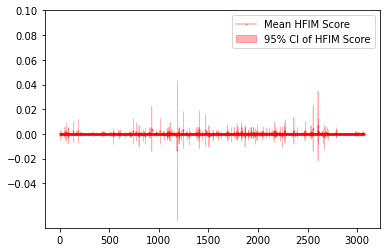

In [357]:
d_plt = 3072
score_hf = SCORE_HF_size40_hfrac_01
score_hf_mean = np.mean(score_hf[:,0:d_plt],axis = 0)
ci_hf_low,ci_hf_up = stats.t.interval(0.95, N-1, loc=np.mean(score_hf[:,0:d_plt],axis = 0), scale=stats.sem(score_hf[:,0:d_plt],axis = 0))

plt.plot(np.arange(1,d_plt+1,1),score_hf_mean,'r',marker='o',alpha = 0.3,markersize=1,label = 'Mean HFIM Score')
plt.fill_between(np.arange(1,d_plt+1,1),ci_hf_low,ci_hf_up,alpha = 0.3,color = 'red',label = '95% CI of HFIM Score')

plt.yticks(np.arange(-0.04,0.1,0.02))
plt.legend()
plt.show()

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


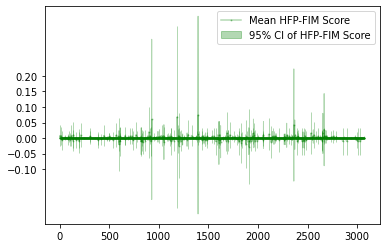

In [358]:
d_plt = 3072
score_hf = SCORE_HFP_size40_hfrac_01
score_hf_mean = np.mean(score_hf[:,0:d_plt],axis = 0)
ci_hf_low,ci_hf_up = stats.t.interval(0.95, N-1, loc=np.mean(score_hf[:,0:d_plt],axis = 0), scale=stats.sem(score_hf[:,0:d_plt],axis = 0))

plt.plot(np.arange(1,d_plt+1,1),score_hf_mean,'g',marker='o',alpha = 0.3,markersize=1,label = 'Mean HFP-FIM Score')
plt.fill_between(np.arange(1,d_plt+1,1),ci_hf_low,ci_hf_up,alpha = 0.3,color = 'g',label = '95% CI of HFP-FIM Score')

plt.yticks(np.arange(-0.1,0.2,0.05))
plt.legend()
plt.show()

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


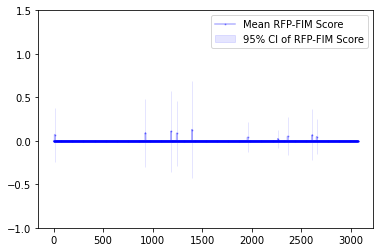

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


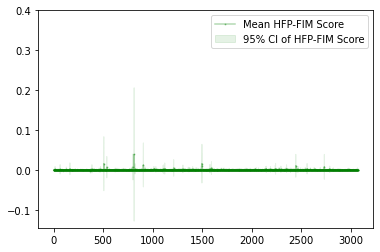

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


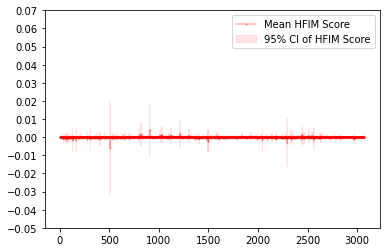

In [413]:

d_plt = 3072
score_hf = SCORE_RFP_size40_hfrac_03
score_hf_mean = np.mean(score_hf[:,0:d_plt],axis = 0)
ci_hf_low,ci_hf_up = stats.t.interval(0.95, N-1, loc=np.mean(score_hf[:,0:d_plt],axis = 0), scale=stats.sem(score_hf[:,0:d_plt],axis = 0))

plt.plot(np.arange(1,d_plt+1,1),score_hf_mean,'b',marker='o',alpha = 0.3,markersize=1,label = 'Mean RFP-FIM Score')
plt.fill_between(np.arange(1,d_plt+1,1),ci_hf_low,ci_hf_up,alpha = 0.1,color = 'b',label = '95% CI of RFP-FIM Score')
plt.yticks(np.arange(-1,2,0.5))
plt.legend()
plt.show()


d_plt = 3072
score_hf = SCORE_HFP_size1000_hfrac_01
score_hf_mean = np.mean(score_hf[:,0:d_plt],axis = 0)
ci_hf_low,ci_hf_up = stats.t.interval(0.95, N-1, loc=np.mean(score_hf[:,0:d_plt],axis = 0), scale=stats.sem(score_hf[:,0:d_plt],axis = 0))

plt.plot(np.arange(1,d_plt+1,1),score_hf_mean,'g',marker='o',alpha = 0.3,markersize=1,label = 'Mean HFP-FIM Score')
plt.fill_between(np.arange(1,d_plt+1,1),ci_hf_low,ci_hf_up,alpha = 0.1,color = 'g',label = '95% CI of HFP-FIM Score')
plt.yticks(np.arange(-0.1,0.5,0.1))
plt.legend()
plt.show()

score_hf = SCORE_HF_size1000_hfrac_01
score_hf_mean = np.mean(score_hf[:,0:d_plt],axis = 0)
ci_hf_low,ci_hf_up = stats.t.interval(0.95, N-1, loc=np.mean(score_hf[:,0:d_plt],axis = 0), scale=stats.sem(score_hf[:,0:d_plt],axis = 0))

plt.plot(np.arange(1,d_plt+1,1),score_hf_mean,'r',marker='o',alpha = 0.3,markersize=1,label = 'Mean HFIM Score')
plt.fill_between(np.arange(1,d_plt+1,1),ci_hf_low,ci_hf_up,alpha = 0.1,color = 'red',label = '95% CI of HFIM Score')


plt.yticks(np.arange(-0.05,0.08,0.01))
plt.legend()
plt.show()

In [452]:
TIC_HFP_0 = np.mean(TIC_HFP[:,:,0],axis = 1)
TIC_HFP_1 = np.mean(TIC_HFP[:,:,1],axis = 1)
TIC_HFP_2 = np.mean(TIC_HFP[:,:,2],axis = 1)
TIC_HFP_3 = np.mean(TIC_HFP[:,:,3],axis = 1)


TIC_HF_0 = np.mean(TIC_HF[:,:,0],axis = 1)
TIC_HF_1 = np.mean(TIC_HF[:,:,1],axis = 1)
TIC_HF_2 = np.mean(TIC_HF[:,:,2],axis = 1)
TIC_HF_3 = np.mean(TIC_HF[:,:,3],axis = 1)

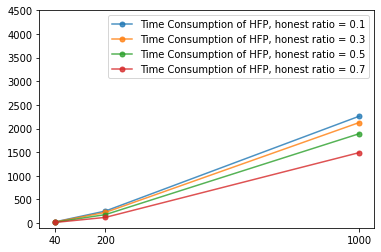

In [450]:
x_axis = 5000/np.geomspace(625, 5, num=4, dtype=int)[1:]
plt.plot(x_axis,TIC_HFP_0,marker='o',alpha = 0.8,markersize=5,label = 'Time Consumption of HFP, honest ratio = 0.1')
plt.plot(x_axis,TIC_HFP_1,marker='o',alpha = 0.8,markersize=5,label = 'Time Consumption of HFP, honest ratio = 0.3')
plt.plot(x_axis,TIC_HFP_2,marker='o',alpha = 0.8,markersize=5,label = 'Time Consumption of HFP, honest ratio = 0.5')
plt.plot(x_axis,TIC_HFP_3,marker='o',alpha = 0.8,markersize=5,label = 'Time Consumption of HFP, honest ratio = 0.7')
plt.yticks(np.arange(0,5000,500))
plt.xticks(x_axis)
plt.legend(loc = 'upper right')
plt.show()

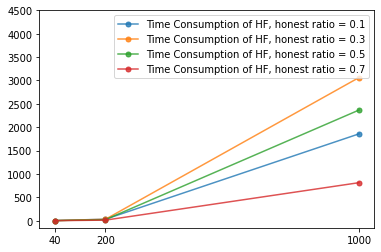

In [453]:
x_axis = 5000/np.geomspace(625, 5, num=4, dtype=int)[1:]
plt.plot(x_axis,TIC_HF_0,marker='o',alpha = 0.8,markersize=5,label = 'Time Consumption of HF, honest ratio = 0.1')
plt.plot(x_axis,TIC_HF_1,marker='o',alpha = 0.8,markersize=5,label = 'Time Consumption of HF, honest ratio = 0.3')
plt.plot(x_axis,TIC_HF_2,marker='o',alpha = 0.8,markersize=5,label = 'Time Consumption of HF, honest ratio = 0.5')
plt.plot(x_axis,TIC_HF_3,marker='o',alpha = 0.8,markersize=5,label = 'Time Consumption of HF, honest ratio = 0.7')
plt.yticks(np.arange(0,5000,500))
plt.xticks(x_axis)
plt.legend(loc = 'upper right')
plt.show()

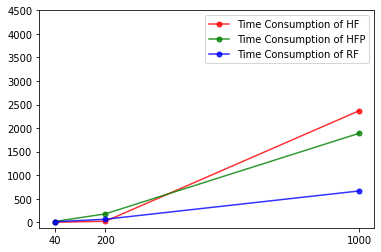

In [445]:
x_axis = 5000/np.geomspace(625, 5, num=4, dtype=int)[1:]
plt.plot(x_axis,TIC_HF_01,'r',marker='o',alpha = 0.8,markersize=5,label = 'Time Consumption of HF')
plt.plot(x_axis,TIC_HFP_01,'g',marker='o',alpha = 0.8,markersize=5,label = 'Time Consumption of HFP')
plt.plot(x_axis,TIC_RFP_01,'b',marker='o',alpha = 0.8,markersize=5,label = 'Time Consumption of RF')
plt.yticks(np.arange(0,5000,500))
plt.xticks(x_axis)
plt.legend(loc = 'upper right')
plt.show()

In [333]:
ERROR_hf_01 = np.hstack((np.load("ERROR_hf_12_p.npy")[:,:,0],np.load("ERROR_hf_345_p.npy")[:,:,0]))
ERROR_hf_02 = np.hstack((np.load("ERROR_hf_12_p.npy")[:,:,1],np.load("ERROR_hf_345_p.npy")[:,:,1]))
ERROR_hf_03 = np.hstack((np.load("ERROR_hf_12_p.npy")[:,:,2],np.load("ERROR_hf_345_p.npy")[:,:,2]))
ERROR_hf_04 = np.hstack((np.load("ERROR_hf_12_p.npy")[:,:,3],np.load("ERROR_hf_345_p.npy")[:,:,3]))
ERROR_rf_01 = np.hstack((np.load("ERROR_rf_12_p.npy"),np.load("ERROR_rf_345_p.npy")))

In [332]:
np.load("ERROR_hf_345_p.npy")

array([[[0.637     , 0.545     , 0.54      , 0.603     ],
        [0.57833333, 0.438     , 0.45233333, 0.58733333],
        [0.53366667, 0.43733333, 0.46766667, 0.49133333]],

       [[0.42033333, 0.40033333, 0.39233333, 0.392     ],
        [0.43266667, 0.39533333, 0.38866667, 0.42933333],
        [0.46566667, 0.40866667, 0.42233333, 0.44933333]],

       [[0.342     , 0.31633333, 0.31      , 0.315     ],
        [0.31666667, 0.30566667, 0.30033333, 0.30933333],
        [0.33533333, 0.31733333, 0.319     , 0.32433333]]])

In [275]:
np.hstack((np.load("ERROR_hf_12.npy")[:,:,0],np.load("ERROR_hf_34.npy")[:,:,0],np.load("ERROR_hf_5.npy")[:,:,0]))

array([[0.66633333, 0.537     , 0.52466667, 0.46533333, 0.53833333],
       [0.38933333, 0.41066667, 0.40333333, 0.42      , 0.459     ],
       [0.334     , 0.33466667, 0.341     , 0.31166667, 0.348     ]])

In [276]:
np.hstack((np.load("ERROR_hf_12.npy")[:,:,1],np.load("ERROR_hf_34.npy")[:,:,1],np.load("ERROR_hf_5.npy")[:,:,1]))

array([[0.65666667, 0.55233333, 0.45233333, 0.438     , 0.59366667],
       [0.36933333, 0.38666667, 0.394     , 0.38433333, 0.45433333],
       [0.302     , 0.29866667, 0.32933333, 0.31133333, 0.33666667]])

[0.18798779 0.10765769 0.04564689]
[0.22691008 0.09389471 0.04309913]
[0.40567462 0.04335989 0.02066468]
[0.39018036 0.08548226 0.02589547]
[0.27324672 0.13490309 0.02953792]


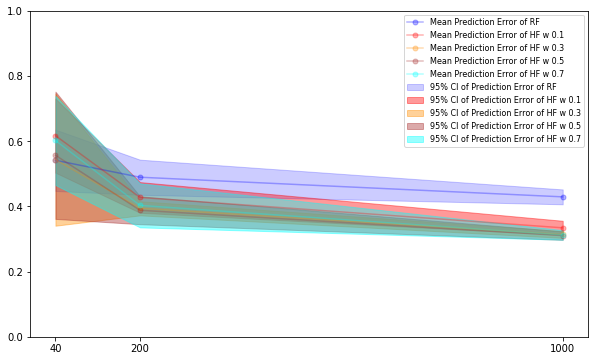

In [356]:
plt.figure(figsize=(10, 6))
ERROR_MEAN = np.mean(ERROR_rf_01,axis = 1)
ci_error_rf_low,ci_error_rf_up = stats.t.interval(0.95, N-1, loc=np.mean(ERROR_rf_01,axis = 1), scale=stats.sem(ERROR_rf_01,axis = 1))
# score_hf_mean[idx]=0
# ci_hf_low[idx] = 0
x_axis = 5000/np.geomspace(625, 5, num=4, dtype=int)[1:]
plt.plot(x_axis,ERROR_MEAN,'b',marker='o',alpha = 0.3,markersize=5,label = 'Mean Prediction Error of RF')
plt.fill_between(x_axis,ci_error_rf_low,ci_error_rf_up,alpha = 0.2,color = 'blue',label = '95% CI of Prediction Error of RF')
width_rf = ci_error_rf_up-ci_error_rf_low
print(width_rf)

ERROR_MEAN = np.mean(ERROR_hf_01,axis = 1)
ci_error_hf_low,ci_error_hf_up = stats.t.interval(0.95, N-1, loc=np.mean(ERROR_hf_01,axis = 1), scale=stats.sem(ERROR_hf_01,axis = 1))
# score_hf_mean[idx]=0
# ci_hf_low[idx] = 0
x_axis = 5000/np.geomspace(625, 5, num=4, dtype=int)[1:]
plt.plot(x_axis,ERROR_MEAN,'r',marker='o',alpha = 0.3,markersize=5,label = 'Mean Prediction Error of HF w 0.1')
plt.fill_between(x_axis,ci_error_hf_low,ci_error_hf_up,alpha = 0.4,color = 'red',label = '95% CI of Prediction Error of HF w 0.1')
width_hf = ci_error_hf_up-ci_error_hf_low
print(width_hf)

ERROR_MEAN = np.mean(ERROR_hf_02,axis = 1)
ci_error_hf_low,ci_error_hf_up = stats.t.interval(0.95, N-1, loc=np.mean(ERROR_hf_02,axis = 1), scale=stats.sem(ERROR_hf_02,axis = 1))
# score_hf_mean[idx]=0
# ci_hf_low[idx] = 0
x_axis = 5000/np.geomspace(625, 5, num=4, dtype=int)[1:]
plt.plot(x_axis,ERROR_MEAN,'darkorange',marker='o',alpha = 0.3,markersize=5,label = 'Mean Prediction Error of HF w 0.3')
plt.fill_between(x_axis,ci_error_hf_low,ci_error_hf_up,alpha = 0.4,color = 'darkorange',label = '95% CI of Prediction Error of HF w 0.3')
width_hf = ci_error_hf_up-ci_error_hf_low
print(width_hf)


ERROR_MEAN = np.mean(ERROR_hf_03,axis = 1)
ci_error_hf_low,ci_error_hf_up = stats.t.interval(0.95, N-1, loc=np.mean(ERROR_hf_03,axis = 1), scale=stats.sem(ERROR_hf_03,axis = 1))
# score_hf_mean[idx]=0
# ci_hf_low[idx] = 0
x_axis = 5000/np.geomspace(625, 5, num=4, dtype=int)[1:]
plt.plot(x_axis,ERROR_MEAN,'brown',marker='o',alpha = 0.3,markersize=5,label = 'Mean Prediction Error of HF w 0.5')
plt.fill_between(x_axis,ci_error_hf_low,ci_error_hf_up,alpha = 0.4,color = 'brown',label = '95% CI of Prediction Error of HF w 0.5')
width_hf = ci_error_hf_up-ci_error_hf_low
print(width_hf)


ERROR_MEAN = np.mean(ERROR_hf_04,axis = 1)
ci_error_hf_low,ci_error_hf_up = stats.t.interval(0.95, N-1, loc=np.mean(ERROR_hf_04,axis = 1), scale=stats.sem(ERROR_hf_04,axis = 1))
# score_hf_mean[idx]=0
# ci_hf_low[idx] = 0
x_axis = 5000/np.geomspace(625, 5, num=4, dtype=int)[1:]
plt.plot(x_axis,ERROR_MEAN,'cyan',marker='o',alpha = 0.3,markersize=5,label = 'Mean Prediction Error of HF w 0.7')
plt.fill_between(x_axis,ci_error_hf_low,ci_error_hf_up,alpha = 0.4,color = 'cyan',label = '95% CI of Prediction Error of HF w 0.7')
width_hf = ci_error_hf_up-ci_error_hf_low
print(width_hf)





plt.xticks(x_axis)
plt.yticks(np.arange(0,1.2,0.2))
plt.legend(fontsize = 8)
plt.show()